In [1646]:
#importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import random
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,classification_report, mean_squared_error

In [1702]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 125)

In [1703]:
df_claims_raw  =pd.read_csv('Car_Claims_For_Insurance.csv')

In [1704]:
df_claims_raw.head()

,ID,KIDSDRIV,BIRTH,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,CAR_TYPE,OLDCLAIM,CLM_FREQ,CLM_AMT,CAR_AGE,URBANICITY
0,351501720,0,03/12/1987,0,0.0,$0,No,NaN,Yes,z_F,z_High School,Student,43,Private,"$2,600",z_SUV,"$4,656",4,$0,1.0,z_Highly Rural/ Rural
1,230928278,0,18/02/1986,2,8.0,"$2,954",Yes,$0,z_No,z_F,<High School,Clerical,21,Private,"$3,100",Sports Car,"$10,099",2,"$6,142",5.0,Highly Urban/ Urban
2,783842613,0,17/02/1986,2,0.0,NaN,Yes,$0,z_No,z_F,Bachelors,Home Maker,31,Private,"$3,180",Sports Car,"$25,235",1,"$2,541",13.0,Highly Urban/ Urban
3,514749997,0,17/08/1985,0,9.0,"$14,484",No,$0,z_No,z_F,<High School,Clerical,20,Private,"$2,950",Sports Car,"$4,518",1,"$4,798",1.0,Highly Urban/ Urban
4,219676153,0,18/10/1984,2,0.0,$0,Yes,$0,z_No,z_F,<High School,Home Maker,23,Private,"$14,500",z_SUV,$0,0,"$3,444",6.0,Highly Urban/ Urban


In [1705]:
#summary of the dataset columns 
df_claims_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10284 entries, 0 to 10283
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10284 non-null  int64  
 1   KIDSDRIV    10284 non-null  int64  
 2   BIRTH       10284 non-null  object 
 3   HOMEKIDS    10284 non-null  int64  
 4   YOJ         9738 non-null   float64
 5   INCOME      9717 non-null   object 
 6   PARENT1     10284 non-null  object 
 7   HOME_VAL    9710 non-null   object 
 8   MSTATUS     10284 non-null  object 
 9   GENDER      10284 non-null  object 
 10  EDUCATION   10284 non-null  object 
 11  OCCUPATION  9619 non-null   object 
 12  TRAVTIME    10284 non-null  int64  
 13  CAR_USE     10284 non-null  object 
 14  BLUEBOOK    10284 non-null  object 
 15  CAR_TYPE    10284 non-null  object 
 16  OLDCLAIM    10284 non-null  object 
 17  CLM_FREQ    10284 non-null  int64  
 18  CLM_AMT     10284 non-null  object 
 19  CAR_AGE     9645 non-null

In [1706]:
# first let us find out the number of missing values in each column
df_missing_val_df=pd.DataFrame({'dtype' : df_claims_raw.dtypes,'Count': df_claims_raw.isnull().sum(),'pct' : df_claims_raw.isnull().sum()/df_claims_raw.shape[0]*100} ) \
.sort_values('pct', ascending =False)
df_missing_val_df

,dtype,Count,pct
OCCUPATION,object,665,6.466356
CAR_AGE,float64,639,6.213536
HOME_VAL,object,574,5.581486
INCOME,object,567,5.513419
YOJ,float64,546,5.309218
ID,int64,0,0.000000
CAR_USE,object,0,0.000000
CLM_AMT,object,0,0.000000
CLM_FREQ,int64,0,0.000000
OLDCLAIM,object,0,0.000000


In [1949]:
df_missing_val_df.to_csv('C:\Assignment\missing_values.csv',  header=True)

There are a few variables,  "OCCUPATION", "CAR_AGE", "HOME_VAL", "INCOME", "YOJ", with missing values.

Also, the target/dependent variable here is "CLM_AMT" 

### Missing Value Treatment

In [1707]:
df_claims_raw.OCCUPATION.value_counts()

z_Blue Collar    2286
Clerical         1589
Professional     1402
Manager          1254
Lawyer           1028
Student           898
Home Maker        843
Doctor            319
Name: OCCUPATION, dtype: int64

In [1708]:
df_claims_raw[df_claims_raw.OCCUPATION.isnull()].EDUCATION.value_counts()

Masters    424
PhD        241
Name: EDUCATION, dtype: int64

In [1709]:
#filling missing values 'OCCUPATION' with based on the relative frequency for esucation levels
OCCUPATION_SAMP = df_claims_raw[(df_claims_raw.EDUCATION.isin(['Masters','PhD']))&(~df_claims_raw.OCCUPATION.isnull())].OCCUPATION.to_list()
em_null = df_claims_raw['OCCUPATION'].isnull().sum()
sampled_list = random.sample(OCCUPATION_SAMP, em_null)
df_claims_raw.loc[df_claims_raw['OCCUPATION'].isnull(),['OCCUPATION']]=sampled_list

#### CAR_AGE

<AxesSubplot:xlabel='CAR_AGE', ylabel='Density'>

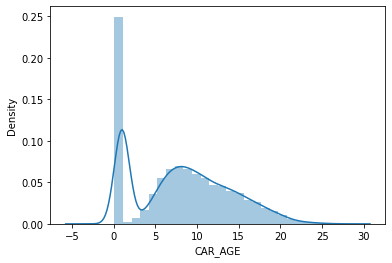

In [1710]:
#Let us look at the distrinution
sns.distplot(df_claims_raw.CAR_AGE)

In [1711]:
#We can use median value fill the missing values
df_claims_raw.CAR_AGE.fillna(df_claims_raw.CAR_AGE.median(), inplace=True)

In [1712]:
#There is one negative vhe negative value can also be replaced by medain 
df_claims_raw.loc[df_claims_raw.CAR_AGE<0, 'CAR_AGE'] =df_claims_raw.CAR_AGE.median()

#### INCOME

The values are in string format here with $ sign. First, we need to clean this a get the numerical values

In [1713]:
df_claims_raw['INCOME'] = df_claims_raw.INCOME.str.replace('$', '') 
df_claims_raw['INCOME'] = df_claims_raw.INCOME.str.replace(',', '') 
df_claims_raw['INCOME'] = df_claims_raw['INCOME'].astype('float64')

As income varies depending on occupation, we will fil the missing values with the medain income of for drivers with same occupation

<AxesSubplot:xlabel='OCCUPATION', ylabel='INCOME'>

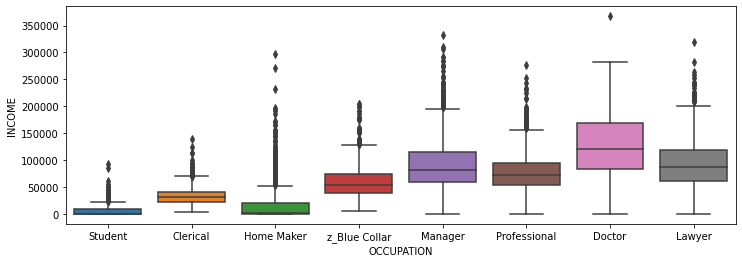

In [1714]:
plt.figure(figsize=(12, 4))
sns.boxplot(data = df_claims_raw, x='OCCUPATION', y='INCOME')

In [1715]:
# filling missing values with medain income of the occupation
df_claims_raw['INCOME'] = df_claims_raw.groupby('OCCUPATION')['INCOME'].transform(lambda x: x.fillna(x.median()))

In [1716]:
df_claims_raw['HOME_VAL']

0             NaN
1              $0
2              $0
3              $0
4              $0
           ...   
10279    $249,026
10280    $181,254
10281    $231,014
10282    $231,014
10283    $159,132
Name: HOME_VAL, Length: 10284, dtype: object

#### HOME_VAL

In [1717]:
#first let us clean the values
df_claims_raw['HOME_VAL'] = df_claims_raw.HOME_VAL.str.replace('$', '') 
df_claims_raw['HOME_VAL'] = df_claims_raw.HOME_VAL.str.replace(',', '') 
df_claims_raw['HOME_VAL'] = df_claims_raw.HOME_VAL.astype('float64')

<AxesSubplot:xlabel='HOME_VAL', ylabel='Density'>

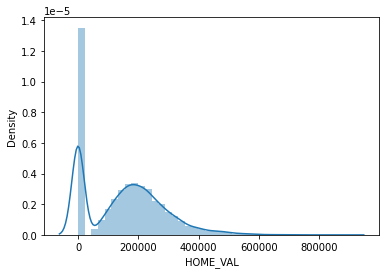

In [1718]:
sns.distplot(df_claims_raw.HOME_VAL)

In [1719]:
# we fill the missing avlues with zero as these are most probably drivers who don own a house
df_claims_raw['HOME_VAL'] =df_claims_raw['HOME_VAL'].fillna(0)

#### YOJ

In [1720]:
## Around 5% missing values .We can fill this with median value
df_claims_raw.YOJ.fillna(df_claims_raw.YOJ.median(), inplace=True)

In [1721]:
# Let us look at the data summary after the missing avlue treatment
df_claims_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10284 entries, 0 to 10283
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10284 non-null  int64  
 1   KIDSDRIV    10284 non-null  int64  
 2   BIRTH       10284 non-null  object 
 3   HOMEKIDS    10284 non-null  int64  
 4   YOJ         10284 non-null  float64
 5   INCOME      10284 non-null  float64
 6   PARENT1     10284 non-null  object 
 7   HOME_VAL    10284 non-null  float64
 8   MSTATUS     10284 non-null  object 
 9   GENDER      10284 non-null  object 
 10  EDUCATION   10284 non-null  object 
 11  OCCUPATION  10284 non-null  object 
 12  TRAVTIME    10284 non-null  int64  
 13  CAR_USE     10284 non-null  object 
 14  BLUEBOOK    10284 non-null  object 
 15  CAR_TYPE    10284 non-null  object 
 16  OLDCLAIM    10284 non-null  object 
 17  CLM_FREQ    10284 non-null  int64  
 18  CLM_AMT     10284 non-null  object 
 19  CAR_AGE     10284 non-nul

So we are good in terms of missing values treatment now

Before we move to further analysis, there are a few data cleaning steps we need to do. As there are a few more amount columns in string format in the data set we will create a custom function to clean this

In [1722]:
def convert_dollar_to_val(x):
    
    return float( (x.replace('$', '')).replace(',', '') )

In [1723]:
#cleaning amount columns in string format
df_claims_raw['CLM_AMT'] = df_claims_raw['CLM_AMT'].apply(convert_dollar_to_val)
df_claims_raw['OLDCLAIM'] = df_claims_raw['OLDCLAIM'] .apply(convert_dollar_to_val)
df_claims_raw['BLUEBOOK'] = df_claims_raw['BLUEBOOK'].apply(convert_dollar_to_val)

<AxesSubplot:xlabel='CLM_AMT', ylabel='Density'>

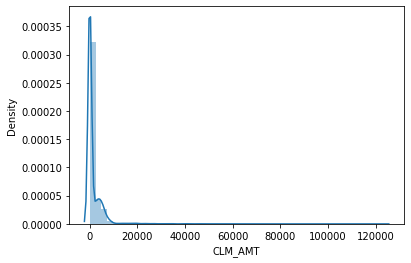

In [1724]:
sns.distplot(df_claims_raw['CLM_AMT'])

The variable 'BIRTH' is not useful to us as it is. Bt we can derive a new variable 'DRIVER_AGE' from this assuming the data is as of today

In [1725]:
df_claims_raw['BIRTH']=pd.to_datetime(df_claims_raw['BIRTH'],format='%d/%m/%Y')
df_claims_raw['DRIVER_AGE']=datetime.datetime.now().year-df_claims_raw['BIRTH'].dt.year

In [1726]:
# we can now drop the unwanted columns 'ID','BIRTH'
df_claims_raw.drop(['ID','BIRTH'], axis=1, inplace=True)

In [ ]:
df_claims_final

Now, we will procedd to univariate and bivariate anlysis of features. We will do this separately for numerical and categorical varaiables. Let us start with numerical(quantitative) varaiables

In [1727]:
#Extracting Numerical columns
num_cols = df_claims_raw.select_dtypes(include = ['float64','int64'] ).columns.to_list()
num_cols

['KIDSDRIV',
 'HOMEKIDS',
 'YOJ',
 'INCOME',
 'HOME_VAL',
 'TRAVTIME',
 'BLUEBOOK',
 'OLDCLAIM',
 'CLM_FREQ',
 'CLM_AMT',
 'CAR_AGE',
 'DRIVER_AGE']

In [1728]:
#lets look at the summary stats of numerical columns
df_claims_raw[num_cols].describe()

,KIDSDRIV,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,OLDCLAIM,CLM_FREQ,CLM_AMT,CAR_AGE,DRIVER_AGE
count,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000
mean,0.169098,0.720440,10.493485,60945.895469,145841.483081,33.419292,15656.865033,4035.851906,0.800467,1512.156068,8.277713,66.888565
std,0.505435,1.116098,3.994825,46840.894067,130422.581932,15.868332,8431.536933,8737.389822,1.153853,4728.742566,5.531648,8.571228
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,34.000000
25%,0.000000,0.000000,9.000000,27786.750000,0.000000,22.000000,9200.000000,0.000000,0.000000,0.000000,3.000000,61.000000
50%,0.000000,0.000000,11.000000,53714.000000,151272.500000,33.000000,14400.000000,0.000000,0.000000,0.000000,8.000000,67.000000
75%,0.000000,1.000000,13.000000,84772.250000,233048.500000,44.000000,20890.000000,4650.500000,2.000000,1145.250000,12.000000,73.000000
max,4.000000,5.000000,19.000000,367030.000000,885282.000000,142.000000,69740.000000,57037.000000,5.000000,123247.000000,28.000000,91.000000


We can see that for many variables, there is a high dfiference between even 95th percentile and max value. 
So, the are chances of outlie values present for these variables. Let us visualize the univariate distribution of the data

#### Univariate Analysis

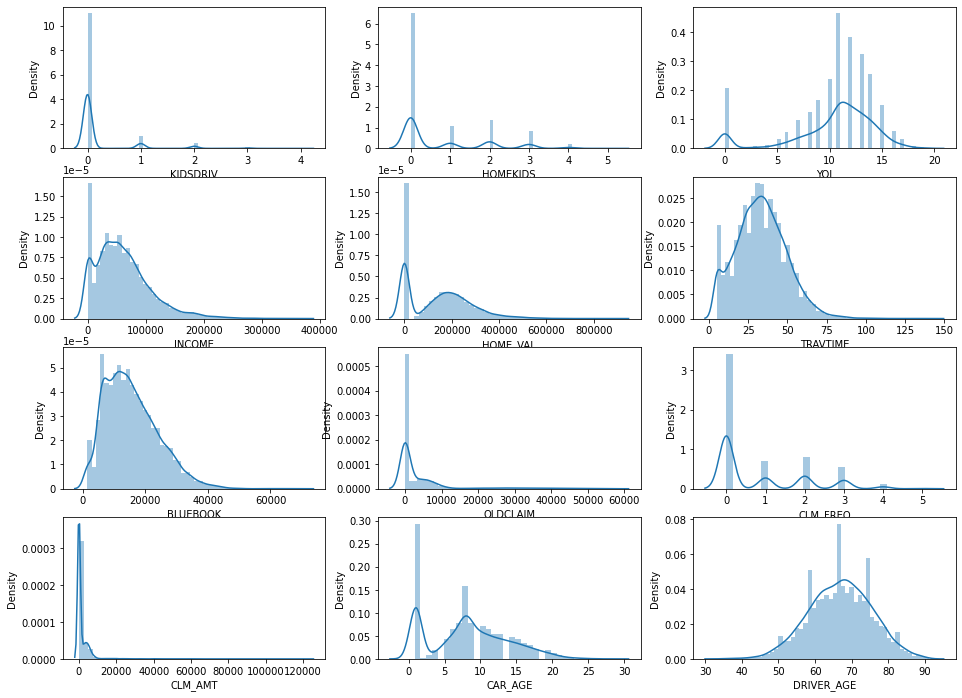

In [1729]:
# creating the distribution plot for all quantitative variables together
fig, ax = plt.subplots(4, 3 , figsize=(16, 12))
col_index = 0
for x in range(4): 
    for y in range(3):
        sns.distplot( df_claims_raw[num_cols[col_index]], ax=ax[x][y])
        col_index+= 1
        if col_index >= len(num_cols):
            break   

We can see that a number of features, mostly the amount varibales,  seem to be having extremely high outlier values. As these values can skew our models we can remove some of these observcatons from the data set

#### Outlier removal

We will adopt a strtegy where we will remove observations for which the values are __above 98th__ percentile for the amount  columns

In [1730]:
df_claims_raw =df_claims_raw[df_claims_raw['INCOME'] < df_claims_raw['INCOME'].quantile(0.98)]
df_claims_raw =df_claims_raw[df_claims_raw['HOME_VAL'] < df_claims_raw['HOME_VAL'].quantile(0.98)]
df_claims_raw =df_claims_raw[df_claims_raw['BLUEBOOK'] < df_claims_raw['BLUEBOOK'].quantile(0.98)]
df_claims_raw =df_claims_raw[df_claims_raw['OLDCLAIM'] < df_claims_raw['OLDCLAIM'].quantile(0.98)]
df_claims_raw =df_claims_raw[df_claims_raw['CLM_AMT'] < df_claims_raw['CLM_AMT'].quantile(0.98)]

#### Bivariate analyis - Numerical columns

We can use scatter plots to lok at the relation between the indepndent numerical varaibles and dependent variable 'CLM_AMT'

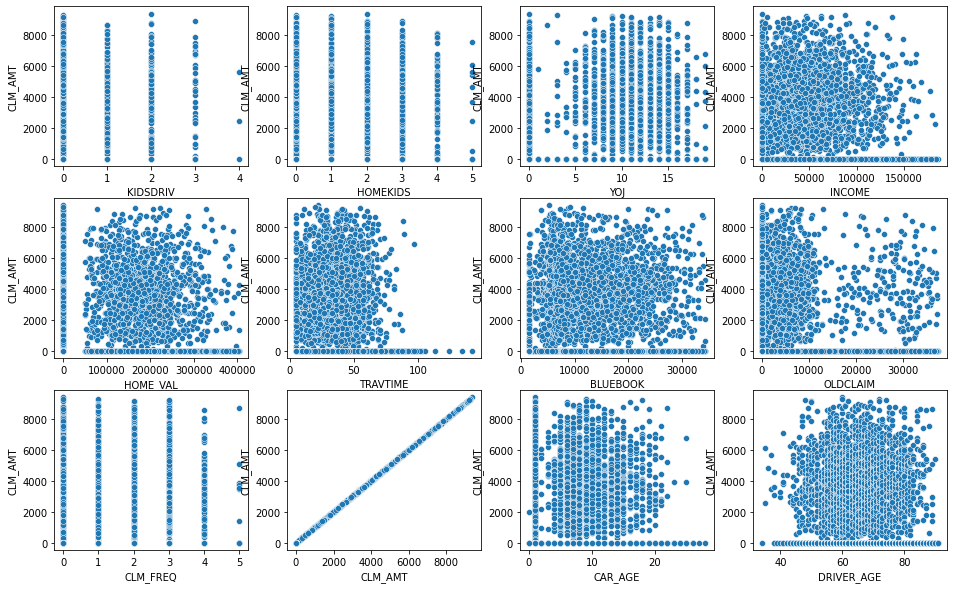

In [1732]:
# Plotting scstter plot of all 12 quntiative variables and Target variable

fig, ax = plt.subplots(3, 4 , figsize=(16, 10))
col_index = 0
for x in range(3): 
    for y in range(4):

        sns.scatterplot(x=df_claims_raw[num_cols[col_index]], y=df_claims_raw['CLM_AMT'] , ax=ax[x][y])
        col_index+= 1

__We can see that there is not much linear relationship going on between the independent variables and the dependent variable. Also, the value of the dependent variable  'CLM_AMT' is zero for most cases. Thsi is not going to help us when building regressoin model or predicting the calim amount and we would have to rethink about our stratgey later__

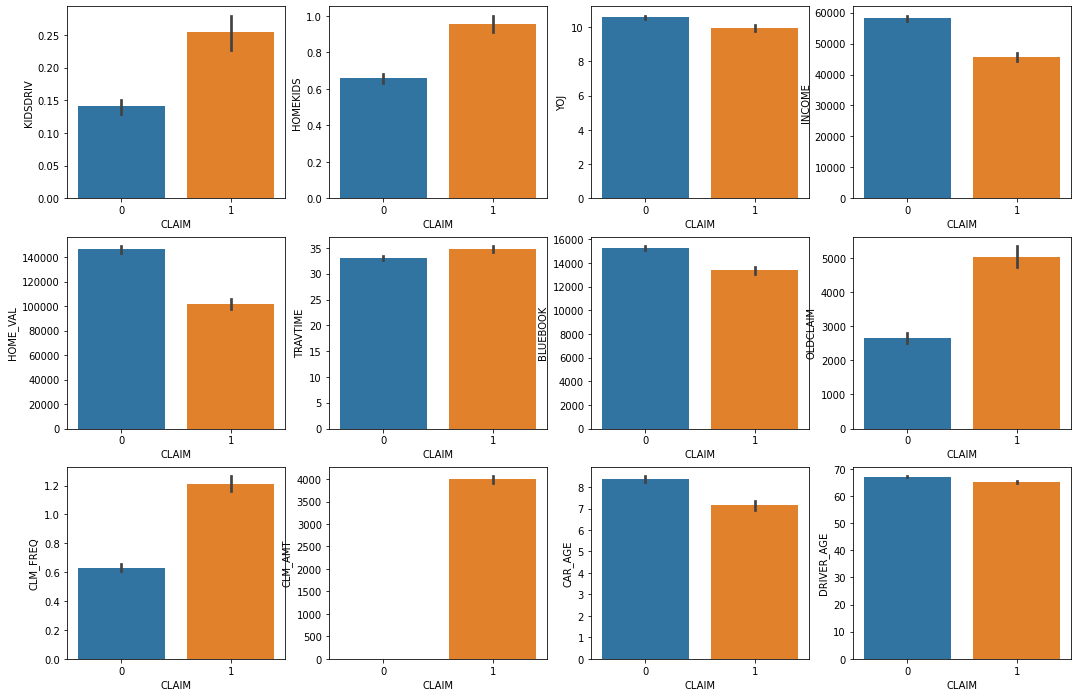

In [1953]:
fig, ax = plt.subplots(3, 4 , figsize=(18, 12))
col_index = 0
for x in range(3): 
    for y in range(4):

        sns.barplot(data =df_claims_final, x='CLAIM', y=num_cols[col_index] , ax=ax[x][y])
        col_index+= 1
        if col_index >= len(num_cols):
            break   

Now, let us look at the heatmap of the correlation matrix of the quatitaive varaibles to see if there are multi-collinerar features as well as the strength of linear relationship with the target

<AxesSubplot:>

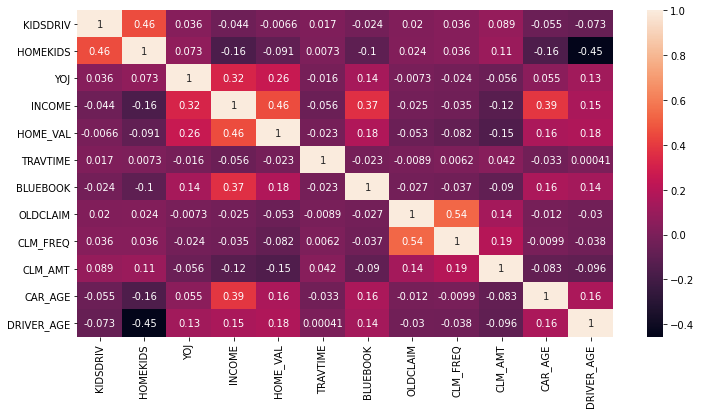

In [1734]:
plt.figure(figsize = (12,6))
sns.heatmap(df_claims_raw[num_cols].corr(), annot=True)

We can see that there are a number of postively multi-collinear relation like between  Home value and income,  old calaim and claim frequency and also some negatively multi-collinear relation like between driver age and home kids going on here. Also, there is no variable having strong correlation with the target variable CLM_AMT. We can see this bettwe from the below graph

Text(0, 0.5, 'Correlation')

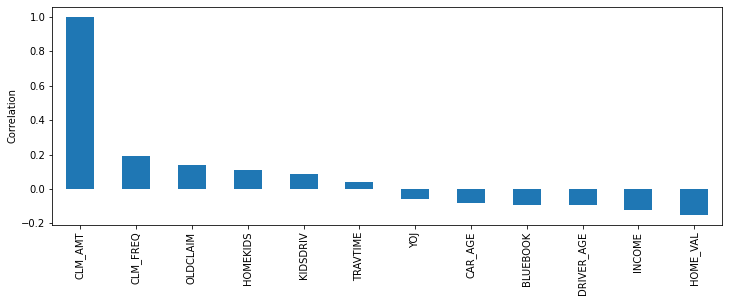

In [1735]:
plt.figure(figsize = (12,4))
df_claims_raw[num_cols].corr()['CLM_AMT'].sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Correlation')

Let us now move our attention to the categorical variables

### Categorical columns

In [1736]:
#Extracting the categorical columns
categ_cols = df_claims_raw.select_dtypes(include = ['object'] ).columns
categ_cols

Index(['PARENT1', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION', 'CAR_USE',
       'CAR_TYPE', 'URBANICITY'],
      dtype='object')

In [1737]:
# checking for percentage of each level in the categ features
for col in categ_cols:
    print(col)
    print(df_claims_raw[col].value_counts(normalize=True)*100)
    print('\n--------------\n')

PARENT1
No     86.819453
Yes    13.180547
Name: PARENT1, dtype: float64

--------------

MSTATUS
Yes     60.361524
z_No    39.638476
Name: MSTATUS, dtype: float64

--------------

GENDER
z_F    54.379169
M      45.620831
Name: GENDER, dtype: float64

--------------

EDUCATION
z_High School    29.933290
Bachelors        28.125672
Masters          19.980633
<High School     15.579944
PhD               6.380461
Name: EDUCATION, dtype: float64

--------------

OCCUPATION
z_Blue Collar    22.918012
Clerical         16.225522
Professional     14.321067
Manager          13.051431
Lawyer           12.169141
Student           9.296320
Home Maker        9.048849
Doctor            2.969658
Name: OCCUPATION, dtype: float64

--------------

CAR_USE
Private       64.5255
Commercial    35.4745
Name: CAR_USE, dtype: float64

--------------

CAR_TYPE
z_SUV          29.018722
Minivan        26.845277
Pickup         17.484399
Sports Car     11.588121
Van             8.424790
Panel Truck     6.638692
Name

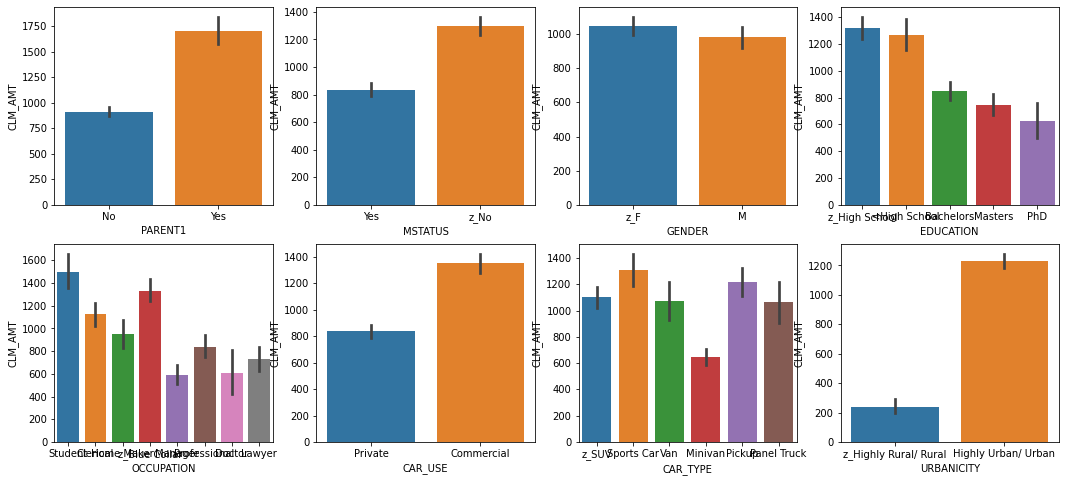

In [1738]:
fig, ax = plt.subplots(2, 4 , figsize=(18, 8))
col_index = 0
for x in range(2): 
    for y in range(4):

        sns.barplot(data =df_claims_raw, x=categ_cols[col_index], y='CLM_AMT' , ax=ax[x][y])
        col_index+= 1
        if col_index >= len(categ_cols):
            break   

In [1507]:
#help(sns.barplot)

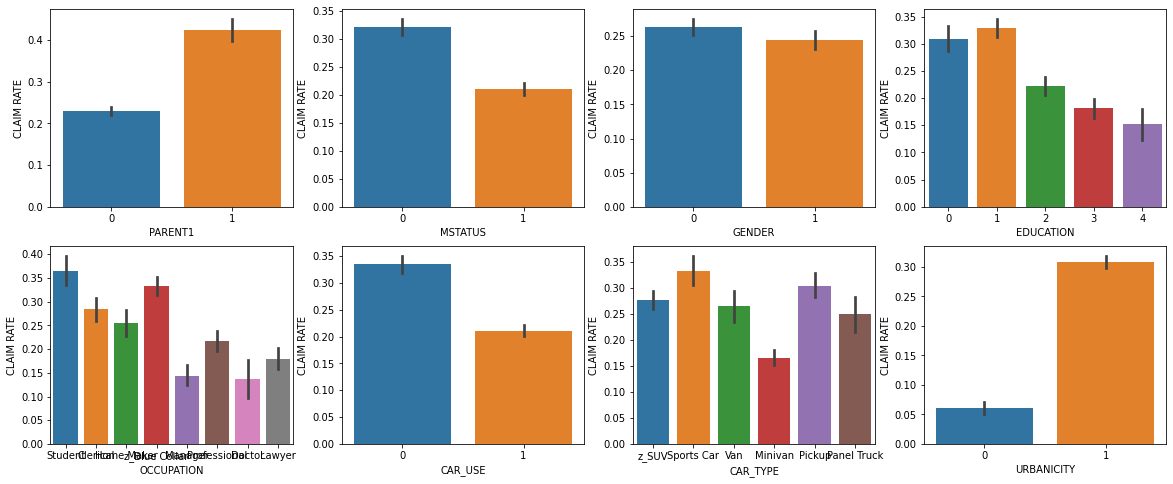

In [1952]:
fig, ax = plt.subplots(2, 4 , figsize=(20, 8))
col_index = 0
for x in range(2): 
    for y in range(4):
        sns.barplot(data =df_claims_raw, x=categ_cols[col_index] , y='CLAIM', ax=ax[x][y])
        ax[x][y].set_ylabel('CLAIM RATE')
        col_index+= 1
        if col_index >= len(categ_cols):
            break   

#### Additional Data Preprocessing

Variables PARENT1, MSTATUS,GENDER,CAR_USE,URBANICITY have binary values. We will binary encode these columns

In [1739]:
df_claims_raw['PARENT1'] =df_claims_raw['PARENT1'] .map({'Yes':1, 'No':0})
df_claims_raw['MSTATUS'] =df_claims_raw['MSTATUS'] .map({'Yes':1, 'z_No':0})
df_claims_raw['GENDER'] =df_claims_raw['GENDER'] .map({'M':1, 'z_F':0})
df_claims_raw['CAR_USE'] =df_claims_raw['CAR_USE'] .map({'Private':1, 'Commercial':0})
df_claims_raw['URBANICITY'] =df_claims_raw['URBANICITY'] .map({'Highly Urban/ Urban':1, 'z_Highly Rural/ Rural':0})

Now, looking a the data description, we can see that many of that variable 'EDUCATION' is ordinal with some qualitative order associated with the levels. We will label encode these columns values numercailly with higher number mapped to increasing qulaity of the levels

In [1740]:
df_claims_raw['EDUCATION'] =df_claims_raw['EDUCATION'] .map({'<High School':0, 'z_High School':1,
                                                            'Bachelors':2, 'Masters':3, 'PhD':4})

In [1741]:
df_claims_raw['CLAIM']  = df_claims_raw['CLM_AMT'].apply(lambda x : 1 if x > 0 else 0 )

Finally, we will create one-hot encoded dummy varaibles for the remaining categorical columns which appear nominal in nature

In [1743]:
df_claims_final = pd.get_dummies(df_claims_raw, columns =['CAR_TYPE', 'OCCUPATION'], drop_first=True)

In [1744]:
df_claims_final.head()

,KIDSDRIV,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,TRAVTIME,CAR_USE,BLUEBOOK,OLDCLAIM,CLM_FREQ,CLM_AMT,CAR_AGE,URBANICITY,DRIVER_AGE,CLAIM,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV,OCCUPATION_Doctor,OCCUPATION_Home Maker,OCCUPATION_Lawyer,OCCUPATION_Manager,OCCUPATION_Professional,OCCUPATION_Student,OCCUPATION_z_Blue Collar
0,0,0,0.0,0.0,0,0.0,1,0,1,43,1,2600.0,4656.0,4,0.0,1.0,0,34,0,0,0,0,0,1,0,0,0,0,0,1,0
1,0,2,8.0,2954.0,1,0.0,0,0,0,21,1,3100.0,10099.0,2,6142.0,5.0,1,35,1,0,0,1,0,0,0,0,0,0,0,0,0
2,0,2,0.0,2657.0,1,0.0,0,0,2,31,1,3180.0,25235.0,1,2541.0,13.0,1,35,1,0,0,1,0,0,0,1,0,0,0,0,0
3,0,0,9.0,14484.0,0,0.0,0,0,0,20,1,2950.0,4518.0,1,4798.0,1.0,1,36,1,0,0,1,0,0,0,0,0,0,0,0,0
4,0,2,0.0,0.0,1,0.0,0,0,0,23,1,14500.0,0.0,0,3444.0,6.0,1,37,1,0,0,0,0,1,0,1,0,0,0,0,0


In [1467]:
#df_claims_final2 = df_claims_final[df_claims_final.CLM_AMT>0]

In [1912]:
df_claims_final.shape

(9294, 31)

__We are now ready with our final cleaned data__

### Problem Objective and Challenges

The objective of the project is to use the dataset to build an model to predict claims and display the results. 

The first option here is to build a linear regression model to predict the claim amount. But there are two challenges here

1. The value of the depnedent variable 'ClAIM_AMT' is zero for most observation(There was no claim for most records)
2. From EDA we saw tha there is hardly any linear relationship going on between the depnedent variable and any of the  independent varibale

We will see this becoming evident when we start building linear regression model later in this exercise


The second option is to build a binary calssification model to predict if a driver is likely to calim insuarnce or not.

__The challenge, though not a big one, here is that the data set is slightly imbalanced with only about 27% of drivers claiming the insurance__

#### Muti-collinearity and its implications

Multi-colliearity is happens when the independent variables are correlated with each other. Like between Home value and income, old calaim and claim frequency and also some negatively multi-collinear relation like between driver age and home kids.

We have already seen from the correlation heatmap in the EDA that there are a numbber of vraibles highly corrleated with each other. 


Multicollinearity affects the interpretation final model as change in one of the variables affect the other. This can also make the variable coefficients in the final model swing wildly, and sometimes signs can invert

Multi-colliearity can be manged by

1. Dropping the less business critical of the correlated varaible
2. Dropping the less interpretable of the correlated variable
3. Create new buisiness interpretable interction variable from the correlated variables and drop the original variables
4. Variable transformations like Factor analysis which combines the effect of a number of correlated variables


### Simple Linear Regression with each independent variable

Now let us split our datat into train and test sets. We will use 70% of the data for training and remaining 30% for testing

In [1786]:
#Creating train/test split
df_train, df_test = train_test_split(df_claims_final, test_size=0.3, random_state=30)

In [1787]:
#scaling the numerical varaibales. We will use minmax scaler
scaler = MinMaxScaler()
final_num_cols = ['KIDSDRIV', 'HOMEKIDS', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME',
       'BLUEBOOK', 'OLDCLAIM', 'CLM_FREQ', 'CAR_AGE', 'DRIVER_AGE','EDUCATION']
df_train[final_num_cols]=scaler.fit_transform(df_train[final_num_cols])
df_test[final_num_cols]=scaler.transform(df_test[final_num_cols])

__As we are going to do SLR for each quantitative independent variable with the dependent variable, let is create function to do this. The function will create the SLR model and then ploat the regressioin fit on a sctter plot with R2 vale and RMSE metrics__

In [1759]:
def Create_Simple_LR (df_train, df_test, feature, target):
    
    #X, and Y for train and test 
    X_train = df_train[feature].values.reshape(-1,1)
    X_test = df_test[feature].values.reshape(-1,1)
    y_train = df_train[target]
    y_test = df_test[target]
    
    #Creating the linear regression model
    LR = LinearRegression()
    LR.fit(X_train, y_train)
    y_train_pred = LR.predict(X_train)
    y_test_pred = LR.predict(X_test)
    
    #Evaluation metrics for train and test
    train_r2 = round(LR.score(X_train, y_train),2)
    test_r2 = round(LR.score(X_test, y_test),2)
    train_rmse = round(np.sqrt(mean_squared_error( y_train, y_train_pred )),2)
    test_rmse  = round(np.sqrt(mean_squared_error( y_test, y_test_pred )),2)
    
    #plotting the model results
    plt.figure(figsize=(7, 4))
    plt.subplot(1,2, 1)
    ax1=plt.gca()
    sns.scatterplot(X_train.ravel(), y_train)
    plt.plot(X_train.ravel(), y_train_pred, color='r')
    plt.text(0.8,0.9, 'R2 = {}\n RMSE = {}'.format(train_r2, train_rmse),  ha = 'center',
             va = 'center', transform=ax1.transAxes)
    plt.title('Train')
    plt.xlabel(feature)
    
    plt.subplot(1,2, 2)
    ax2=plt.gca()
    sns.scatterplot(X_test.ravel(), y_test)
    plt.plot(X_test.ravel(), y_test_pred, color='r')
    plt.text(0.8, 0.9, 'R2 = {}\n RMSE = {}'.format(test_r2, test_rmse),  ha = 'center', va = 'center', transform=ax2.transAxes)
    plt.title('Test')
    plt.xlabel(feature)
    plt.tight_layout()

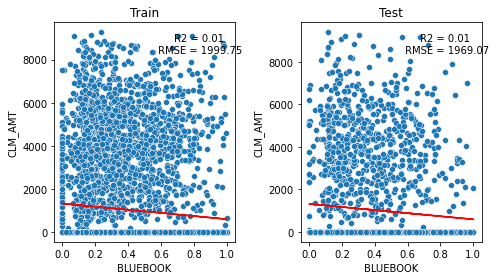

In [1749]:
#SLR for BLUEBOOK
Create_Simple_LR(df_train, df_test, feature='BLUEBOOK' ,target='CLM_AMT' )

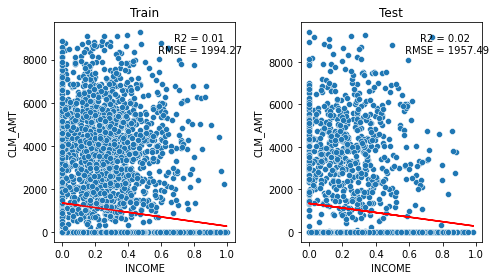

In [1750]:
#SLR for INCOME
Create_Simple_LR(df_train, df_test, 'INCOME' ,'CLM_AMT' )

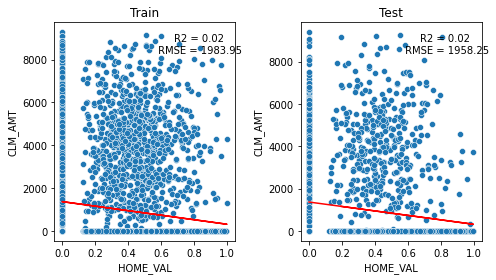

In [1751]:
#SLR for HOME_VAL
Create_Simple_LR(df_train, df_test, 'HOME_VAL' ,'CLM_AMT' )

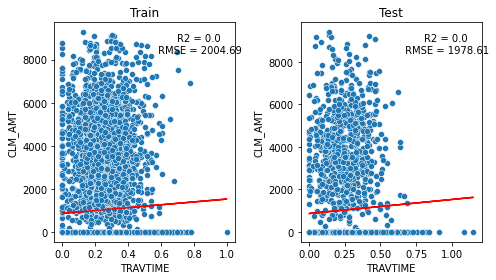

In [1752]:
#SLR for TRAVTIME
Create_Simple_LR(df_train, df_test, 'TRAVTIME' ,'CLM_AMT' )

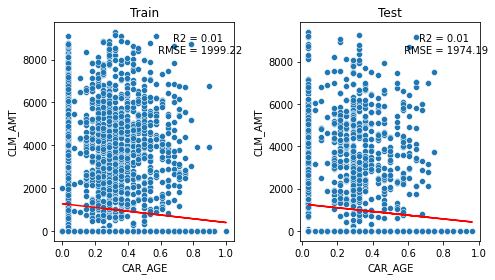

In [1753]:
#SLR for CAR_AGE
Create_Simple_LR(df_train, df_test, 'CAR_AGE' ,'CLM_AMT' )

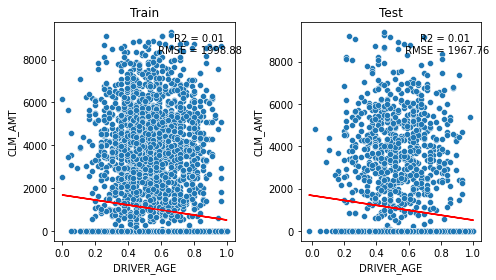

In [1754]:
#SLR for DRIVER_AGE
Create_Simple_LR(df_train, df_test, 'DRIVER_AGE' ,'CLM_AMT' )

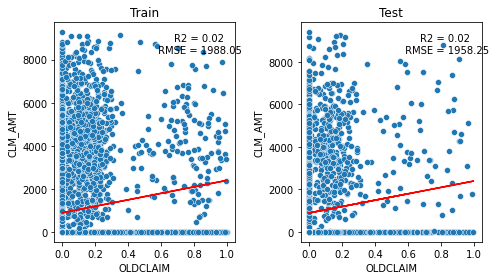

In [1755]:
#SLR for OLDCLAIM
Create_Simple_LR(df_train, df_test, 'OLDCLAIM' ,'CLM_AMT' )

This further confirms the lack of non-linear relationship between the independent and dependent variable. The R2 values are very low for both train and test set and also, the RMSE is very high 

In [1411]:
#from sklearn.decomposition import PCA
#pca_obj = PCA(n_components=4)
#pca_obj.fit(X_train[[col for col in final_num_cols if col !='CLM_AMT']])
#x_train_pca = pca_obj.transform(X_train[[col for col in  final_num_cols if col !='CLM_AMT']])
#x_test_pca = pca_obj.transform(X_test[[col for col in  final_num_cols if col !='CLM_AMT']])
#print(pca_obj.explained_variance_ratio_)

In [1412]:
#pca_obj.components_.T

### Fatcor Anlysis for the variables

In [1756]:
from  factor_analyzer import FactorAnalyzer

In [1410]:
#help(FactorAnalyzer)

In [1760]:
#creating FactorAnalyzer object and fitting for the qunatittaive variables to extarct four factors
fa = FactorAnalyzer(4, rotation='varimax')
fa.fit (df_claims_final[final_num_cols])
fa.loadings_

array([[-0.03019672,  0.41729315,  0.04205613,  0.02294106],
       [-0.07661403,  1.00950688, -0.02485248,  0.00381818],
       [-0.00874597,  0.06019874,  0.48058251, -0.00186229],
       [ 0.42624568, -0.09215435,  0.70343793, -0.00411213],
       [ 0.13889354, -0.06976398,  0.5413942 , -0.06245135],
       [-0.04801895,  0.00354612, -0.0373792 , -0.00195746],
       [ 0.17381101, -0.08384199,  0.34782936, -0.02111126],
       [-0.00707011,  0.02152362, -0.02359618,  0.60597747],
       [ 0.00858395,  0.03295315, -0.04707677,  0.88353071],
       [ 0.66603724, -0.10357473,  0.13028103, -0.00567695],
       [ 0.1220506 , -0.3962899 ,  0.20041435, -0.02073911],
       [ 0.95289179, -0.13405873,  0.19333104, -0.00894783]])

In [1917]:
#creating a dataframe of final factors with corresponding loadings
factor_df=pd.DataFrame(fa.loadings_,index=final_num_cols, columns = ['Factor1','Factor2','Factor3','Factor4'])
factor_df

,Factor1,Factor2,Factor3,Factor4
KIDSDRIV,-0.030197,0.417293,0.042056,0.022941
HOMEKIDS,-0.076614,1.009507,-0.024852,0.003818
YOJ,-0.008746,0.060199,0.480583,-0.001862
INCOME,0.426246,-0.092154,0.703438,-0.004112
HOME_VAL,0.138894,-0.069764,0.541394,-0.062451
TRAVTIME,-0.048019,0.003546,-0.037379,-0.001957
BLUEBOOK,0.173811,-0.083842,0.347829,-0.021111
OLDCLAIM,-0.007070,0.021524,-0.023596,0.605977
CLM_FREQ,0.008584,0.032953,-0.047077,0.883531
CAR_AGE,0.666037,-0.103575,0.130281,-0.005677


Looking at the magnitude of the loading values, we can interepret the factors as below

1. Factor1 -> Education, Income, Car Age values are higher. So this indicates overall eduication and financial status of the driver
2. Factor2 -> Indicates generally if driver is having kids 
3. Factor3 -> INCOME, HOME_VAL, BLUEBOOK are high. So, the factor indicates gerally well-off car owners
3. Factor4 -> OLDCLAIM, CLM_FREQ are highe. So the factor indicates previous claims.

__Based on this we can name the fdactor as below__

__Factor1 : Educated and Financially Stable__

__Factor2 : Has Kids__

__Factor3 : Generally Well-off__

__Factor4: previous claims history__

In [1942]:
factor_df.to_csv('C:\Assignment\Factors.csv',  header=True)

### Multiple Linear Regression

Here we are required to

Perform Multiple linear regression with a dependent variable and the four pertinent independent variables. Comment on the Model output and validity

We can  find out the most four pertinent independent variables by using  __Recursive Feature Elimination (RFE)__ 

Sklearn has a built in capability for doing this. This modeule uses the vraiable importance meassure of an estimator and outputs the most important n features based on that

In [ ]:
from sklearn.feature_selection import RFE

In [1788]:
# creates the X and y vars for train and test
X_train_regr = df_train.drop(['CLAIM','CLM_AMT'], axis=1)
y_train_regr = df_train['CLM_AMT']
y_test_regr = df_test['CLM_AMT']
X_test_regr = df_test.drop(['CLAIM','CLM_AMT'], axis=1)

In [1981]:
#creates RFE for linear regression and fits on tarin data
lm = LinearRegression()
lm.fit(X_train_regr, y_train_regr )
rfe = RFE(lm, 4)             
rfe = rfe.fit(X_train_regr, y_train_regr)

In [1982]:
#creating RFE rank dataframe for four most important features
df_feature_importance=pd.DataFrame({'Vars': X_train_regr.columns,'Selectd' :rfe.support_,'Rank':rfe.ranking_}).sort_values(by='Rank').reset_index(drop=True)
df_feature_importance[df_feature_importance.Selectd]

,Vars,Selectd,Rank
0,KIDSDRIV,True,1
1,INCOME,True,1
2,CLM_FREQ,True,1
3,TRAVTIME,True,1


Now let us create the MLR model for the best four features and check the results

In [1983]:
#Building the base model
x_train_best_four=X_train_regr[['KIDSDRIV', 'CLM_FREQ','INCOME','TRAVTIME']]
lm_best_four = LinearRegression()
lm_best_four.fit(x_train_best_four, y_train_regr)
print(lm_best_four.score(x_train_best_four, y_train_regr))

0.06282366053472144


As expected, the R2 value is very low as we dont have any strong linear relationship between the depndent and independent variables

__To illustrate, Multiple Linear Reressoin, let us now see if we can precit the income variable taking the other variables as independent variables and doing regresson based on the most important four varaiables identified by RFE__

In [1792]:
X_train_regr2 = df_train.drop(['CLAIM','INCOME'], axis=1)
y_train_regr2 = df_train['INCOME']

In [1793]:
X_test_regr2 = df_test.drop(['CLAIM','INCOME'], axis=1)
y_test_regr2 = df_test['INCOME']

In [1985]:
lm2 = LinearRegression()
lm2.fit(X_train_regr2, y_train_regr2 )
rfe2 = RFE(lm2, 4)             
rfe2 = rfe.fit(X_train_regr2, y_train_regr2)

In [1986]:
df_feature_importance2=pd.DataFrame({'Vars': X_train_regr2.columns,'Selectd' :rfe2.support_,'Rank':rfe2.ranking_}).sort_values(by='Rank').reset_index(drop=True)
df_feature_importance2[df_feature_importance2.Selectd]

,Vars,Selectd,Rank
0,HOME_VAL,True,1
1,EDUCATION,True,1
2,OCCUPATION_Home Maker,True,1
3,OCCUPATION_Student,True,1


In [1987]:
x_train2_best_four=X_train_regr2[['HOME_VAL', 'EDUCATION','OCCUPATION_Home Maker','OCCUPATION_Student']]
lm2_best_four = LinearRegression()
lm2_best_four.fit(x_train2_best_four, y_train_regr2)
print(lm2_best_four.score(x_train2_best_four, y_train_regr2))

0.5532836090599638


In [1990]:
print(lm2_best_four.score(X_test_regr2[['HOME_VAL', 'EDUCATION','OCCUPATION_Home Maker','OCCUPATION_Student']], y_test_regr2))

0.5581743189515357


Teh R2 value is much higher now and the  train and test score are almost the same. So, the model is not overfitting

For Linear Regressoin to be applicable, we need to check for the validity of the below two assumptions
1. The error terms are normally distributed with zero mean
2. The error terms have constant varaince around each value of prediction

Text(0.5, 0, 'Residual')

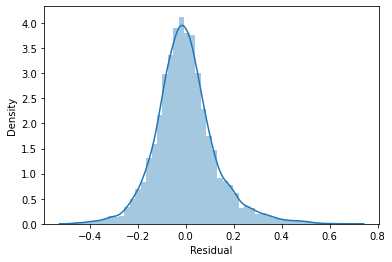

In [1796]:
#Distribution of residual
y_train_predict = lm2.predict(X_train_regr2)
residual =  y_train_regr2-y_train_predict
sns.distplot(residual)
plt.xlabel('Residual')

The residuals look to be normally distributed with mean around zero

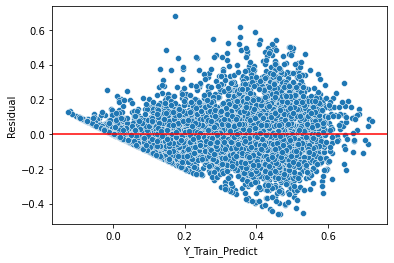

In [1797]:
#varaince of Residual plot
sns.scatterplot(y_train_predict,residual)
plt.xlabel('Y_Train_Predict')
plt.ylabel('Residual')
plt.axhline(0, color='r')

There is no visible pattern or considerable variance in the error terms

In [1772]:
df_claims_final.head()

,KIDSDRIV,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,TRAVTIME,CAR_USE,BLUEBOOK,OLDCLAIM,CLM_FREQ,CLM_AMT,CAR_AGE,URBANICITY,DRIVER_AGE,CLAIM,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV,OCCUPATION_Doctor,OCCUPATION_Home Maker,OCCUPATION_Lawyer,OCCUPATION_Manager,OCCUPATION_Professional,OCCUPATION_Student,OCCUPATION_z_Blue Collar
0,0,0,0.0,0.0,0,0.0,1,0,1,43,1,2600.0,4656.0,4,0.0,1.0,0,34,0,0,0,0,0,1,0,0,0,0,0,1,0
1,0,2,8.0,2954.0,1,0.0,0,0,0,21,1,3100.0,10099.0,2,6142.0,5.0,1,35,1,0,0,1,0,0,0,0,0,0,0,0,0
2,0,2,0.0,2657.0,1,0.0,0,0,2,31,1,3180.0,25235.0,1,2541.0,13.0,1,35,1,0,0,1,0,0,0,1,0,0,0,0,0
3,0,0,9.0,14484.0,0,0.0,0,0,0,20,1,2950.0,4518.0,1,4798.0,1.0,1,36,1,0,0,1,0,0,0,0,0,0,0,0,0
4,0,2,0.0,0.0,1,0.0,0,0,0,23,1,14500.0,0.0,0,3444.0,6.0,1,37,1,0,0,0,0,1,0,1,0,0,0,0,0


### Classification Trees

In [117]:
from sklearn.ensemble import RandomForestClassifier

In [1369]:
from sklearn.tree import DecisionTreeClassifier

In [1798]:
# creates the X and y vars for train and test
X_train_clsf = df_train.drop(['CLAIM','CLM_AMT'], axis=1)
y_train_clsf = df_train['CLAIM']
X_test_regr = df_test.drop(['CLAIM','CLM_AMT'], axis=1)
y_test_regr= df_test['CLM_AMT']

First let us try the deciosn tree classifier

### Decison Tree Classifier

In [1822]:
dtree = DecisionTreeClassifier( random_state = 42, min_samples_leaf=2)
dtree.fit(X_train_clsf, y_train_clsf)

DecisionTreeClassifier(min_samples_leaf=2, random_state=42)

In [1823]:
# Accuracy Score on Train
dtree.score(X_train_clsf, y_train_clsf)

0.9560338201383551

Let us look at other evaluation metrics like preciosn and recall and f1-score. We can use sklearn.metrics modules classification_report method for this

In [1838]:
# Evaluation metrics on Train
print(classification_report(y_train_clsf,dtree.predict(X_train_clsf) ))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4833
           1       0.97      0.85      0.91      1672

    accuracy                           0.96      6505
   macro avg       0.96      0.92      0.94      6505
weighted avg       0.96      0.96      0.96      6505



In [1839]:
# Evaluation metrics on Test
print(classification_report(y_test_clsf,dtree.predict(X_test_clsf) ))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2073
           1       0.70      0.63      0.66       716

    accuracy                           0.84      2789
   macro avg       0.79      0.77      0.78      2789
weighted avg       0.83      0.84      0.83      2789



In [1840]:
# Accuracy Score on Test
dtree.score(X_test_clsf, y_test_clsf)

0.8368590892793116

__The model has over all good accuracy on train(95%) and test(84%) data.This is expected as the data is imabalanced. However, there is signficant varaince between traind test accuracies. So, the model might be slightly overfitting__

__The varaince is even higher for recall vlaue of minority class (1) . So, we can try tree truncation or pruning to try to reduce the overfit__

But beofore we do this, let us create a function to collect the evaluation metrics together as we will be using this more later

In [1841]:
def get_model_eval_metrics(model,  X_train, y_train, X_test, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print('Train Metrics \n')
    
    print('Accuracy: {}'. format(model.score(X_train,y_train)))
    print('\n')
    print(classification_report(y_train,y_train_pred))
    #plot_confusion_matrix(model, X_train, y_train,
                            #cmap=plt.cm.Blues)
    print('\n')
    
    print('Test Metrics \n')
    
    print('Accuracy: {}'. format(model.score(X_test,y_test)))
    print('\n')
    print(classification_report(y_test ,y_test_pred))
    #plot_confusion_matrix(model, X_test, y_test,
                           #cmap=plt.cm.Blues)
    

Tree truncation can be achieved by hyperparamter tuning using GridSearchCV

In [1842]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [1843]:
param_grid  = {  "min_samples_leaf" : [2, 4, 8, 10],
               "min_samples_split" : [  4, 10, 12, 16], 'max_depth' : [10, 20, 30, 50]}

dtree2 = DecisionTreeClassifier(  random_state=42)
cv_dtree = GridSearchCV(estimator=dtree2, param_grid=param_grid,scoring = 'accuracy')
cv_dtree.fit(X_train_clsf, y_train_clsf)
#cv_dtree.best_params_

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, 30, 50],
                         'min_samples_leaf': [2, 4, 8, 10],
                         'min_samples_split': [4, 10, 12, 16]},
             scoring='accuracy')

In [1832]:
cv_dtree.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=8, random_state=42)

In [1844]:
#getting the best model with tuned paramters
dtree_tuned = cv_dtree.best_estimator_

In [1946]:
#geeting the detaure importance based on mean decrease in gini
feature_imp_dttuned=pd.DataFrame({'feature' : X_train_clsf.columns, 'importance':dtree_tuned.feature_importances_}).sort_values('importance', ascending=False)
feature_imp_dttuned

,feature,importance
12,OLDCLAIM,0.156399
3,INCOME,0.121743
11,BLUEBOOK,0.098235
5,HOME_VAL,0.082100
15,URBANICITY,0.077764
8,EDUCATION,0.076625
16,DRIVER_AGE,0.071075
9,TRAVTIME,0.069808
10,CAR_USE,0.038579
2,YOJ,0.035559


In [1845]:
#getting the performance for the tuned model
get_model_eval_metrics(dtree_tuned,  X_train_clsf, y_train_clsf, X_test_clsf, y_test_clsf)

Train Metrics 

Accuracy: 0.8348962336664104


              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4833
           1       0.74      0.55      0.63      1672

    accuracy                           0.83      6505
   macro avg       0.80      0.74      0.76      6505
weighted avg       0.83      0.83      0.83      6505



Test Metrics 

Accuracy: 0.7884546432413051


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2073
           1       0.62      0.45      0.52       716

    accuracy                           0.79      2789
   macro avg       0.72      0.68      0.69      2789
weighted avg       0.77      0.79      0.78      2789



Now there is lesser varaince between the train and test performance and overall test performance is satisfactory. So, this is a more generalisable model than the first one

#### Pruning The Decions Tree

In [2050]:
## getting the cost_complexity_path paramter for the base decisoin tree
tree_full = DecisionTreeClassifier(random_state=42, min_samples_leaf=2)
path = tree_full.cost_complexity_pruning_path(X_train_clsf, y_train_clsf)
ccp_alphas = path.ccp_alphas

train_scores =[]
test_scores =[]

#creatung trees for different ccp_alphas and collectiong the train and test scores
for alpha in ccp_alphas:
    
    tree_pruned = DecisionTreeClassifier(ccp_alpha= alpha, random_state=42, min_samples_leaf=2)
    tree_pruned.fit(X_train_clsf, y_train_clsf) 

    train_scores.append (tree_pruned.score(X_train_clsf, y_train_clsf))
    test_scores.append (tree_pruned.score(X_test_clsf, y_test_clsf))
    
    #train_scores.append (recall_score(y_train_clsf, tree_pruned.predict(X_train_clsf) ))
    #test_scores.append (recall_score( y_test_clsf, tree_pruned.predict(X_test_clsf)))


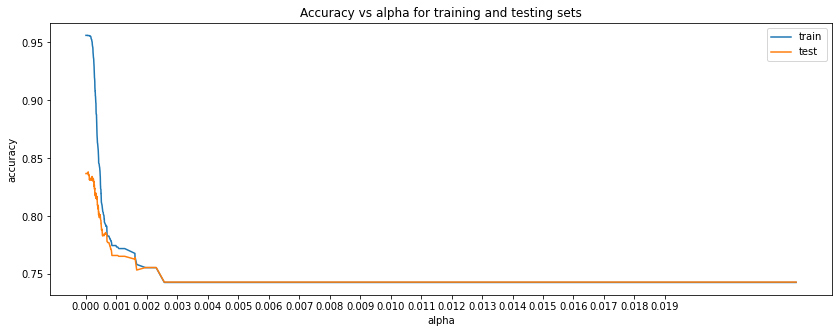

In [2051]:
#plotting the test and train accuracies for different value sof ccp_alpha. 
fig, ax = plt.subplots(figsize=(14,5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores,  label="train",  )
ax.plot(ccp_alphas, test_scores, label="test" )
ax.legend()
ax.set_xticks(np.arange(0.00, 0.020,0.001 ))
plt.show()

Looking at the graph, the train and test accuarcies are high enough and closer for alph around 0.0003

In [2064]:
## building the final pruned tree for cp_alpha=0.0003
dtree_pruned_final = DecisionTreeClassifier( random_state = 42, min_samples_leaf=2, ccp_alpha=0.0003)
dtree_pruned_final.fit(X_train_clsf, y_train_clsf)

DecisionTreeClassifier(ccp_alpha=0.0003, min_samples_leaf=2, random_state=42)

In [2065]:
#checking the metrics for the pruned tree
get_model_eval_metrics(dtree_pruned_final,  X_train_clsf, y_train_clsf, X_test_clsf, y_test_clsf)

Train Metrics 

Accuracy: 0.9082244427363566


              precision    recall  f1-score   support

           0       0.92      0.96      0.94      4833
           1       0.87      0.76      0.81      1672

    accuracy                           0.91      6505
   macro avg       0.89      0.86      0.87      6505
weighted avg       0.91      0.91      0.91      6505



Test Metrics 

Accuracy: 0.8192900681247759


              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2073
           1       0.66      0.62      0.64       716

    accuracy                           0.82      2789
   macro avg       0.76      0.75      0.76      2789
weighted avg       0.82      0.82      0.82      2789



Now we have reasonable good scores for both train and test and the varaince in performance has come down. So, this is a more generalisable model athan the base tree model.

### Random Forest

In [1854]:
#building the base untuned model

rf = RandomForestClassifier(n_estimators = 30, min_samples_leaf=4,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,     
                           random_state = 42)
rf.fit(X_train_clsf, y_train_clsf)

RandomForestClassifier(min_samples_leaf=4, n_estimators=30, n_jobs=-1,
                       oob_score=True, random_state=42)

In [1855]:
#getting the model performance
get_model_eval_metrics(rf,  X_train_clsf, y_train_clsf, X_test_clsf, y_test_clsf)

Train Metrics 

Accuracy: 0.900999231360492


              precision    recall  f1-score   support

           0       0.89      0.99      0.94      4833
           1       0.95      0.65      0.77      1672

    accuracy                           0.90      6505
   macro avg       0.92      0.82      0.85      6505
weighted avg       0.91      0.90      0.89      6505



Test Metrics 

Accuracy: 0.8461814270347795


              precision    recall  f1-score   support

           0       0.85      0.97      0.90      2073
           1       0.84      0.50      0.62       716

    accuracy                           0.85      2789
   macro avg       0.84      0.73      0.76      2789
weighted avg       0.85      0.85      0.83      2789



The base random forest model is performing better than the base and tuned deciosn tree model. Let us try to improve this by hyperparamter tuning 

In [1908]:
param_grid  = {  "min_samples_leaf" : [2, 4, 8, 10],"n_estimators": [20, 30,  50, 80],
               "min_samples_split" : [4, 8, 10, 12]}

rf2 = RandomForestClassifier(  random_state=42)
cv_rf2= GridSearchCV(estimator=rf2, param_grid=param_grid,scoring = 'accuracy')
cv_rf2.fit(X_train_clsf, y_train_clsf)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'min_samples_leaf': [2, 4, 8, 10],
                         'min_samples_split': [4, 8, 10, 12],
                         'n_estimators': [20, 30, 50, 80]},
             scoring='accuracy')

In [1909]:
cv_rf2.best_estimator_

RandomForestClassifier(min_samples_leaf=2, min_samples_split=8, n_estimators=80,
                       random_state=42)

In [1910]:
rf_tuned = cv_rf2.best_estimator_

In [1911]:
get_model_eval_metrics(rf_tuned,  X_train_clsf, y_train_clsf, X_test_clsf, y_test_clsf)

Train Metrics 

Accuracy: 0.9409684857801691


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4833
           1       0.99      0.78      0.87      1672

    accuracy                           0.94      6505
   macro avg       0.96      0.89      0.92      6505
weighted avg       0.94      0.94      0.94      6505



Test Metrics 

Accuracy: 0.870204374327716


              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2073
           1       0.88      0.57      0.69       716

    accuracy                           0.87      2789
   macro avg       0.88      0.77      0.81      2789
weighted avg       0.87      0.87      0.86      2789



The tuned model looks slightly better with less variancebetween train and test , at same time giving alsmost as good performance metrics

In [1947]:
feature_imp_rftuned=pd.DataFrame({'feature' : X_train_clsf.columns, 'importance':rf_tuned.feature_importances_}).sort_values('importance', ascending=False)
feature_imp_rftuned

,feature,importance
3,INCOME,0.098419
11,BLUEBOOK,0.096613
16,DRIVER_AGE,0.089961
9,TRAVTIME,0.084616
5,HOME_VAL,0.080111
15,URBANICITY,0.078874
12,OLDCLAIM,0.077816
2,YOJ,0.050966
14,CAR_AGE,0.050421
13,CLM_FREQ,0.044858


In [1948]:
feature_imp_rftuned.to_csv('C:\Assignment\Feature_imp.csv',  header=True)

In [1880]:
#from imblearn.over_sampling import ADASYN
#sm = ADASYN(random_state = 42) 
#X_train_adsyn, y_train_adsyn = sm.fit_sample(X_train_clsf, y_train_clsf)

In [1897]:
#rf_adsyn = RandomForestClassifier(n_estimators = 100, max_depth =30,
                          # n_jobs = -1,
                          # oob_score = True,
                          # bootstrap = True,
                         # min_samples_leaf= 4, min_samples_split=10,          
                          # random_state = 42)

#rf_adsyn .fit(X_train_adsyn, y_train_adsyn )
#random_forest.fit(X_train_Norm, Y_train)
#print('Training Score: {:.2f} \nOOB Score: {:.2f} \n Test Score: {:.2f}'.format(rf.score(X_train_adsyn, y_train_adsyn ), 
                                                                                            # rf.oob_score_,
                                                                                            # rf.score(X_test_clsf, y_test_clsf)))

The next step is to create and evaluate other models like KNN ,Naive Bayes ,Logistic Regression

In [1859]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

### KNN

In [1857]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_clsf, y_train_clsf)

KNeighborsClassifier()

In [1858]:
get_model_eval_metrics(knn,  X_train_clsf, y_train_clsf, X_test_clsf, y_test_clsf)

Train Metrics 

Accuracy: 0.8238278247501921


              precision    recall  f1-score   support

           0       0.85      0.92      0.89      4833
           1       0.71      0.54      0.61      1672

    accuracy                           0.82      6505
   macro avg       0.78      0.73      0.75      6505
weighted avg       0.81      0.82      0.82      6505



Test Metrics 

Accuracy: 0.7941914664754393


              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2073
           1       0.63      0.47      0.54       716

    accuracy                           0.79      2789
   macro avg       0.73      0.69      0.70      2789
weighted avg       0.78      0.79      0.78      2789



### Naive Bayes

In [1898]:
NB = GaussianNB() 
NB.fit(X_train_clsf, y_train_clsf)  

GaussianNB()

In [1900]:
get_model_eval_metrics(NB,  X_train_clsf, y_train_clsf, X_test_clsf, y_test_clsf)

Train Metrics 

Accuracy: 0.7380476556495004


              precision    recall  f1-score   support

           0       0.85      0.78      0.82      4833
           1       0.49      0.61      0.55      1672

    accuracy                           0.74      6505
   macro avg       0.67      0.70      0.68      6505
weighted avg       0.76      0.74      0.75      6505



Test Metrics 

Accuracy: 0.7400501972032987


              precision    recall  f1-score   support

           0       0.86      0.78      0.82      2073
           1       0.50      0.63      0.55       716

    accuracy                           0.74      2789
   macro avg       0.68      0.70      0.69      2789
weighted avg       0.77      0.74      0.75      2789



This model seems to be better at minority calss recall, but the majority recall has degraded as a trade-off

### Logistic Regression

In [1865]:
Log_Regr = LogisticRegression()
Log_Regr.fit(X_train_clsf, y_train_clsf)

LogisticRegression()

In [1866]:
get_model_eval_metrics(Log_Regr,  X_train_clsf, y_train_clsf, X_test_clsf, y_test_clsf)

Train Metrics 

Accuracy: 0.7866256725595696


              precision    recall  f1-score   support

           0       0.81      0.93      0.87      4833
           1       0.65      0.37      0.47      1672

    accuracy                           0.79      6505
   macro avg       0.73      0.65      0.67      6505
weighted avg       0.77      0.79      0.77      6505



Test Metrics 

Accuracy: 0.7866618859806382


              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2073
           1       0.63      0.40      0.49       716

    accuracy                           0.79      2789
   macro avg       0.73      0.66      0.68      2789
weighted avg       0.77      0.79      0.77      2789



__Out of thse three models, KNN has the best performance looking both train and test evaluatoin metrics__

In [ ]:
##from sklearn.tree import plot_tree
##fig = plt.figure(figsize=(18,40))
##_= plot_tree(clf_dt.best_estimator_, feature_names=X_train.columns , class_names=['NO CLAIM', 'CLAIM'],filled=True)

### Bagging And Boosting

In the next step we are required to

Apply both bagging and boosting modeling procedures to create 2 models and compare its accuracy with the best model of the above step

#### Bagging

Bagging (Bootstrap Aggregation) is the prcess of combining a number of parallelly learnt homogenous independent models and using some kind of deterministic averaging or majority voting process. RaandomForest that we used earlier is an example of ensmble bagging model.

In [1882]:
from sklearn.ensemble import BaggingClassifier

In [1893]:
# BaggingClassifier by default uses DecisionTreeClassifier as the estimator
# Here we are combing 30 such trees and training on randomly selected 70% of the tarining samples 
bag_model=BaggingClassifier(n_estimators=30, max_samples=0.7)
bag_model.fit(X_train_clsf, y_train_clsf)

BaggingClassifier(max_samples=0.7, n_estimators=30)

In [1894]:
get_model_eval_metrics(bag_model,  X_train_clsf, y_train_clsf, X_test_clsf, y_test_clsf)

Train Metrics 

Accuracy: 0.9790930053804766


              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4833
           1       0.99      0.92      0.96      1672

    accuracy                           0.98      6505
   macro avg       0.98      0.96      0.97      6505
weighted avg       0.98      0.98      0.98      6505



Test Metrics 

Accuracy: 0.8845464324130513


              precision    recall  f1-score   support

           0       0.89      0.96      0.93      2073
           1       0.85      0.67      0.75       716

    accuracy                           0.88      2789
   macro avg       0.87      0.81      0.84      2789
weighted avg       0.88      0.88      0.88      2789



### Boosting

Boosting is the prcess of combining a number homogenous  models sequentially in a very adaptative way. A number of weak leaners are combined form a strong leaner. Let us try the GradientBoostingClassifier which is one of those boosting classifiers

In [1895]:
from  sklearn.ensemble import GradientBoostingClassifier
gb_model=GradientBoostingClassifier()
gb_model.fit(X_train_clsf, y_train_clsf)

GradientBoostingClassifier()

In [1896]:
get_model_eval_metrics(gb_model,  X_train_clsf, y_train_clsf, X_test_clsf, y_test_clsf)

Train Metrics 

Accuracy: 0.8187548039969255


              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4833
           1       0.76      0.43      0.55      1672

    accuracy                           0.82      6505
   macro avg       0.79      0.69      0.72      6505
weighted avg       0.81      0.82      0.80      6505



Test Metrics 

Accuracy: 0.8114019361778415


              precision    recall  f1-score   support

           0       0.83      0.94      0.88      2073
           1       0.72      0.43      0.54       716

    accuracy                           0.81      2789
   macro avg       0.77      0.69      0.71      2789
weighted avg       0.80      0.81      0.79      2789



In [1878]:
#creating custom function to capture the evaluation metric
def get_model_comparison_metrics(model,   X_train, y_train, X_test, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    return pd.DataFrame( {'model_name' :model.__class__.__name__ , 
                          'Data': ['Train', 'Test'],
                          'Accuracy': [model.score( X_train, y_train), model.score( X_test, y_test)],
                         'Recall' :[recall_score(y_train,y_train_pred), recall_score(y_test,y_test_pred)],
                          'Precison': [precision_score(y_train,y_train_pred),precision_score(y_test,y_test_pred)],
                          'F1-Score':  [f1_score(y_train,y_train_pred), f1_score(y_test,y_test_pred)]})  

In [1879]:
get_model_comparison_metrics(gb_model,  X_train_clsf, y_train_clsf, X_test_clsf, y_test_clsf)

,model_name,Data,Accuracy,Recall,Precison,F1-Score
0,GradientBoostingClassifier,Train,0.818755,0.433612,0.757576,0.551541
1,GradientBoostingClassifier,Test,0.811402,0.431564,0.721963,0.540210


In [1950]:
#getting the metrics for the previous 3 models and the bagging and boosting models

final_metrics=pd.DataFrame()
for model in  [rf_tuned, dtree_tuned, knn, NB, Log_Regr, bag_model, gb_model]:
    
    final_metrics = final_metrics.append(get_model_comparison_metrics(model,  X_train_clsf, y_train_clsf, X_test_clsf, y_test_clsf))
final_metrics

,model_name,Data,Accuracy,Recall,Precison,F1-Score
0,RandomForestClassifier,Train,0.940968,0.779904,0.987879,0.871658
1,RandomForestClassifier,Test,0.870204,0.569832,0.883117,0.692699
0,DecisionTreeClassifier,Train,0.834896,0.552632,0.739200,0.632444
1,DecisionTreeClassifier,Test,0.788455,0.452514,0.620690,0.523425
0,KNeighborsClassifier,Train,0.823828,0.535287,0.708070,0.609673
1,KNeighborsClassifier,Test,0.794191,0.470670,0.633459,0.540064
0,GaussianNB,Train,0.738048,0.610646,0.492285,0.545115
1,GaussianNB,Test,0.740050,0.631285,0.495071,0.554942
0,LogisticRegression,Train,0.786626,0.371411,0.648225,0.472243
1,LogisticRegression,Test,0.786662,0.398045,0.634744,0.489270


<AxesSubplot:xlabel='model_name', ylabel='Accuracy'>

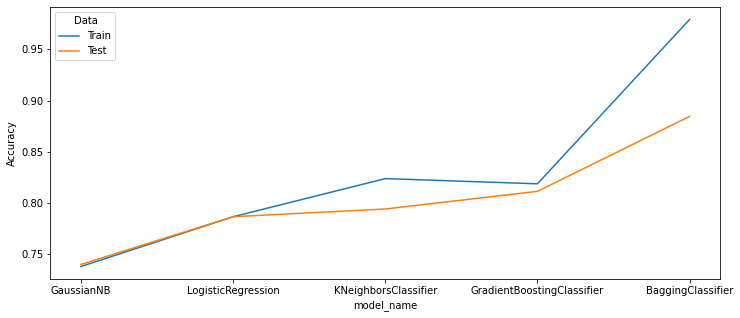

In [1936]:
#plotting accuarcy
plt.figure(figsize=(12,5))
sns.lineplot(data=final_metrics.sort_values('Accuracy'), x='model_name', y='Accuracy', hue='Data' )

<AxesSubplot:xlabel='model_name', ylabel='Recall'>

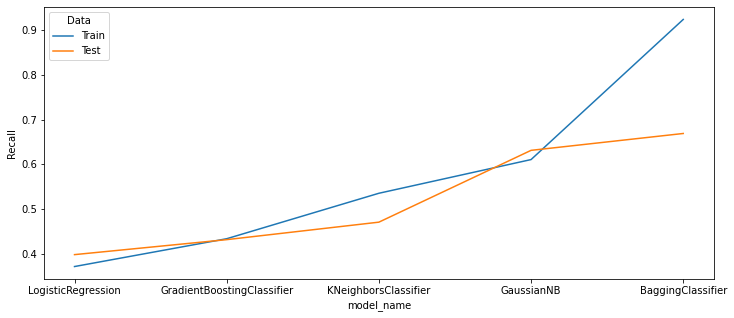

In [1937]:
#plotting recall
plt.figure(figsize=(12,5))
sns.lineplot(data=final_metrics.sort_values('Recall'), x='model_name', y='Recall', hue='Data' )

Bagging model has good number on tarin and test, but ther is high varaince between traing test values and might need further hyperpaarmetr tuning. 

In [1951]:
# for the Power BI Dashboard
final_metrics.to_csv('C:\Assignment\Final_Model_Performances.csv',  header=True)

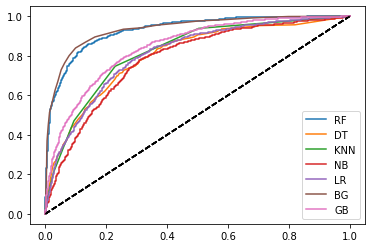

In [1959]:
#Plotting the ROC curve for all models. Higher the area under ROC curve, better the model

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

for model_name, model in zip(['RF', 'DT', 'KNN', 'NB', 'LR', 'BG', 'GB'] 
                             ,[rf_tuned, dtree_tuned, knn, NB, Log_Regr, bag_model, gb_model]):
    fpr, tpr = roc_curve(y_test_clsf,model.predict_proba(X_test_clsf)[:,1])[:2]
    plt.plot(fpr,tpr, label=model_name)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()



In [1979]:
# for the Power BI Dashboard

final_probs=pd.DataFrame()
for model_name, model in zip(['RF', 'DT', 'KNN', 'NB', 'LR', 'BG', 'GB'] 
                             ,[rf_tuned, dtree_tuned, knn, NB, Log_Regr, bag_model, gb_model]):
    PR_DICT_TEST = { 'model' : model_name, 'Data':'Test',
        'FPR': roc_curve(y_test_clsf,model.predict_proba(X_test_clsf)[:,1])[0],
               'TPR': roc_curve(y_test_clsf,model.predict_proba(X_test_clsf)[:,1])[1]}
    PR_DICT_TRAIN = { 'model' : model_name, 'Data':'Train',
        'FPR': roc_curve(y_train_clsf, model.predict_proba(X_train_clsf)[:,1])[0],
               'TPR': roc_curve(y_train_clsf,model.predict_proba(X_train_clsf)[:,1])[1]}
    
    PR_DF_Train = pd.DataFrame(PR_DICT_TRAIN)
    PR_DF_Test = pd.DataFrame(PR_DICT_TEST)
    final_probs=final_probs.append(PR_DF_Train, ignore_index=True)
    final_probs=final_probs.append(PR_DF_Test, ignore_index=True)
final_probs

,model,Data,FPR,TPR
0,RF,Train,0.000000,0.000000
1,RF,Train,0.000000,0.000598
2,RF,Train,0.000000,0.463517
3,RF,Train,0.000207,0.463517
4,RF,Train,0.000207,0.513158
...,...,...,...,...
9442,GB,Test,0.971056,0.998603
9443,GB,Test,0.971056,1.000000
9444,GB,Test,0.971539,1.000000
9445,GB,Test,0.972504,1.000000


In [1980]:
# for the Power BI Dashboard
final_probs.to_csv('C:\Assignment\ROC.csv',  header=True)